In [441]:
#Liên kết dữ liệu từ drive
from google.colab import drive
drive.mount('/content/drive')
#Thêm các thư viện
import numpy as np
import matplotlib.pyplot as plt
import cv2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3/ Dice recognition

Ảnh 1 xúc xắc

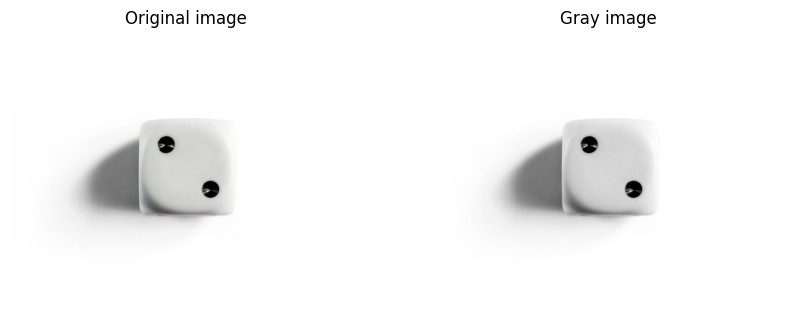

In [442]:
img = cv2.imread('/content/drive/MyDrive/Image_processing/Project/Project_2/img/one_dice.jpg', cv2.IMREAD_UNCHANGED)
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1); plt.imshow(img); plt.axis('off'); plt.title("Original image")
plt.subplot(1,2,2); plt.imshow(imgGray, cmap='gray'); plt.axis('off'); plt.title("Gray image")
plt.show()

Sau đó dùng Canny  
Giúp phát hiện cạnh của xúc xắc

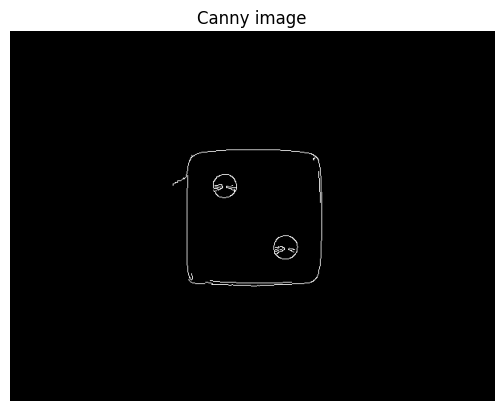

In [443]:
# Phát hiện cạnh ngưỡng 1 là 9, ngưỡng 2 là 150, lọc sobel với kernel 3x3
edges = cv2.Canny(imgGray, 9, 150, 3)

#Hiển thị ảnh
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.title('Canny image')
plt.show()

Chúng ta tiến hành lấp đầy chấm tròn của xúc xắc và kẻ lại cạnh cho xúc xắc

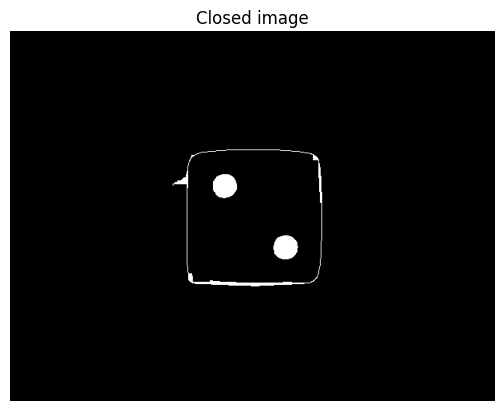

In [444]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)

plt.imshow(closed, cmap='gray')
plt.axis('off')
plt.title('Closed image')
plt.show()

Dùng HoughCircles để xác định các hình tròn xuất hiện trong ảnh closed, sau đó ta được một mảng gồm tọa độ và bán kính của các hình tròn đó, từ đó dùng circle để vẽ các đường tròn

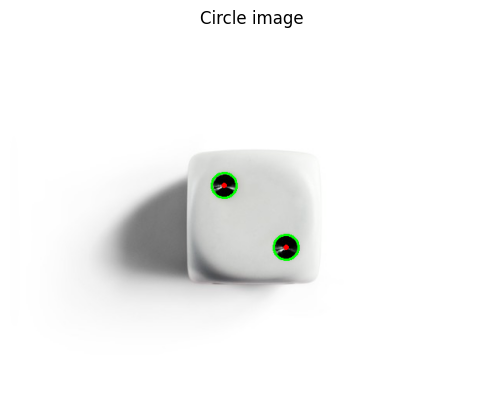

In [445]:
circles = cv2.HoughCircles(closed,cv2.HOUGH_GRADIENT,1.1,20,param1=150,param2=30,minRadius=5,maxRadius=55)
circleImg = img.copy()

if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # Vẽ đường tròn
        cv2.circle(circleImg, (i[0], i[1]), i[2], (0, 255, 0), 2) #màu xanh lá
        # Vẽ tâm đường tròn
        cv2.circle(circleImg, (i[0], i[1]), 2, (255, 0, 0), 2) #màu đỏ

plt.imshow(circleImg)
plt.axis('off')
plt.title('Circle image')
plt.show()

Sau đó ta tìm đường biên của mặt xúc xắc

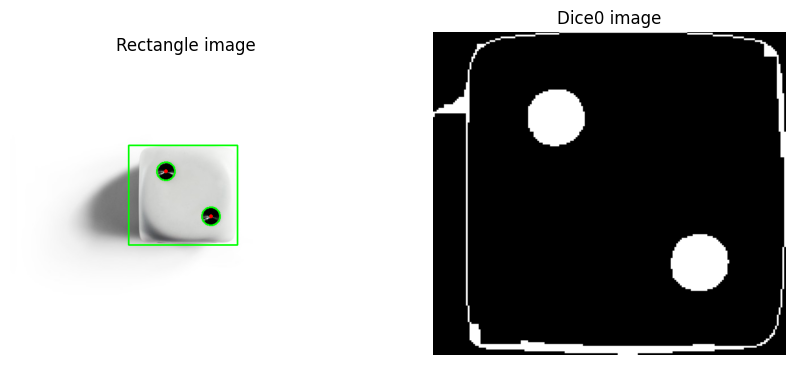

In [446]:
contours, hierarchy = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#tìm đường viền lớn nhất
x0, y0, w0, h0 = cv2.boundingRect(contours[0])
#vẽ hình chữ nhật cho từng xúc xắc
rectangleImg = circleImg.copy()
cv2.rectangle(rectangleImg, (x0, y0), (x0+w0, y0+h0), (0,255,0),2)
#cắt vùng ảnh chỉ chứa xúc xắc
dice0 = closed[y0: y0 + h0, x0: x0 + w0]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1); plt.imshow(rectangleImg); plt.axis('off'); plt.title("Rectangle image")
plt.subplot(1,2,2); plt.imshow(dice0, cmap='gray'); plt.axis('off'); plt.title("Dice0 image")
plt.show()

Sau đó ta tiến hành đếm các chấm tròn trên xúc xắc

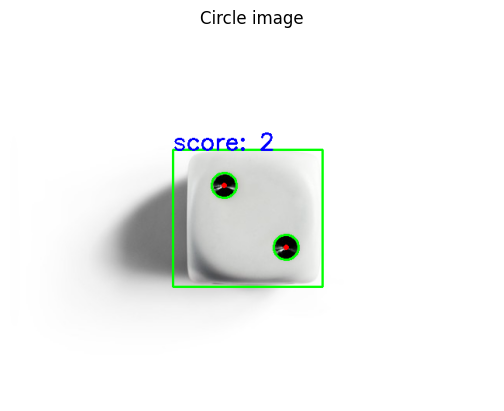

In [447]:
circles0 = cv2.HoughCircles(dice0,cv2.HOUGH_GRADIENT,1.1,20,param1=150,param2=20,minRadius=5,maxRadius=55)
imgPutText = rectangleImg.copy()
#Hiển thị
cv2.putText(imgPutText, f'score: {len(circles0[0])}', (x0, y0), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
plt.imshow(imgPutText)
plt.axis('off')
plt.title('Circle image')
plt.show()

Hiển thị toàn bộ kết quả

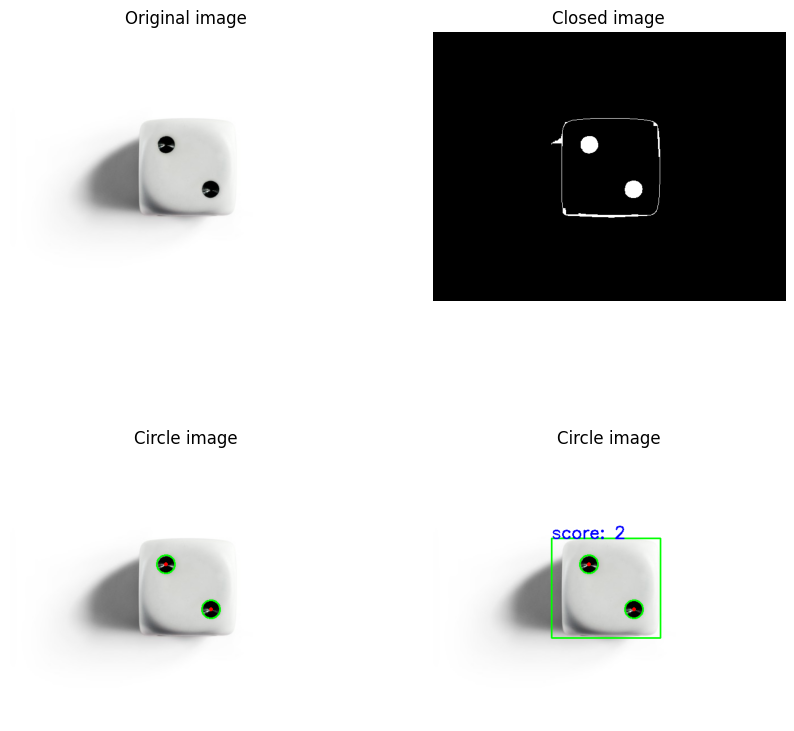

In [448]:
plt.figure(figsize=(10,10))
plt.subplot(221); plt.axis('off'); plt.imshow(img); plt.title("Original image")
plt.subplot(222); plt.axis('off'); plt.imshow(closed, cmap='gray'); plt.title("Closed image")
plt.subplot(223); plt.axis('off'); plt.imshow(circleImg); plt.title("Circle image")
plt.subplot(224); plt.axis('off'); plt.imshow(imgPutText); plt.title("Circle image")
plt.show()

Tiến hành viết hàm

In [492]:
def process_dice_image(img, k, minRadius, maxRadius, ite, hinh):

    # Bước 1: Chuyển ảnh sang ảnh xám
    grayImg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Bước 2: Phát hiện cạnh
    if(hinh == 1):
      edges = cv2.Canny(grayImg, 9, 150, 3)
    else:
      _, thresh = cv2.threshold(grayImg,150,255, cv2.THRESH_BINARY)
      edges = cv2.Canny(thresh, 9, 150, 3)

    # Bước 3: Tạo kernel và thực hiện phép đóng
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k, k))
    if(hinh == 1):
      closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=ite)
    else:
      closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=ite)

    # Bước 4: Tìm các đường tròn trong ảnh
    circles = cv2.HoughCircles(cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=ite), cv2.HOUGH_GRADIENT, 1.1, 20, param1=150, param2=30, minRadius=minRadius, maxRadius=maxRadius)
    circleImg = img.copy()

    # Bước 5: Vẽ các đường tròn và tâm của chúng
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            # Vẽ đường tròn
            cv2.circle(circleImg, (i[0], i[1]), i[2], (0, 255, 0), 2)  # Màu xanh lá
            # Vẽ tâm đường tròn
            cv2.circle(circleImg, (i[0], i[1]), 2, (255, 0, 0), 2)  # Màu đỏ

    # Bước 6: Tìm các đường viền lớn nhất
    contours, hierarchy = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #print(len(contours))

    resultImg = circleImg.copy()  # Ảnh kết quả
    for contour in contours:
        # Vẽ đường viền
        x0, y0, w0, h0 = cv2.boundingRect(contour)
        cv2.rectangle(resultImg, (x0, y0), (x0 + w0, y0 + h0), (0, 255, 0), 5)

        # Tách các ảnh ra riêng
        dice = closed[y0:y0 + h0, x0:x0 + w0]

        # Xác định số lượng các chấm tròn trên ảnh riêng
        circles = cv2.HoughCircles(dice, cv2.HOUGH_GRADIENT, 1.2, 20, param1=150, param2=25, minRadius=5, maxRadius=55)
        # Ghi kết quả
        score = 0
        if circles is not None:
            circles = np.uint16(np.around(circles))
            score = len(circles[0])  # Số lượng chấm tròn

        # Ghi kết quả số điểm
        cv2.putText(resultImg, f'score: {score}', (x0, y0 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    return imgGray, closed, circleImg, resultImg

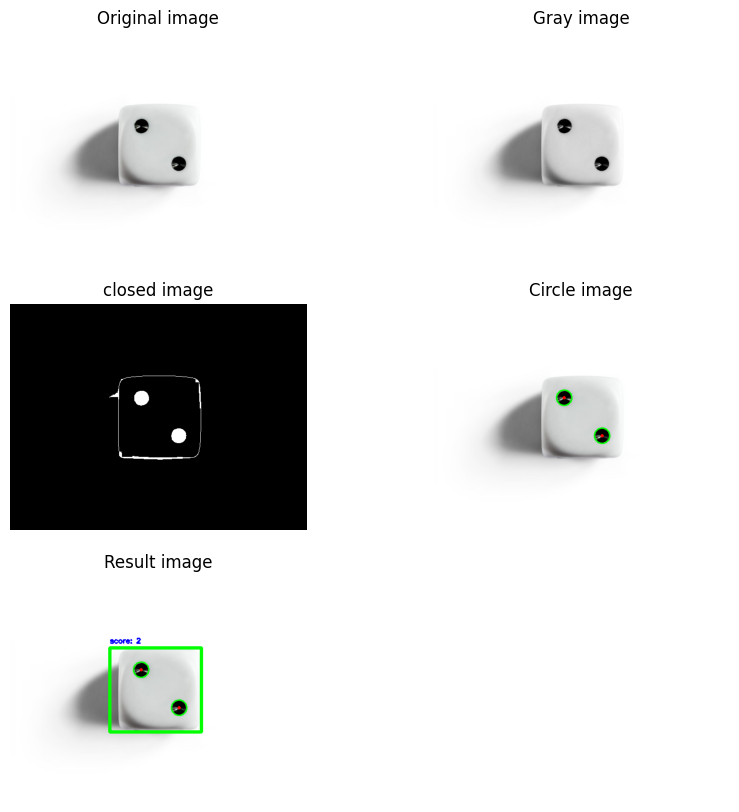

In [490]:
img = cv2.imread('/content/drive/MyDrive/Image_processing/Project/Project_2/img/one_dice.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#k = 9, minRadius = 5, maxRadius = 55, ite = 1, hinh 1
anh1, anh2, anh3, anh4 = process_dice_image(img, 9, 5, 55, 2, 1)
plt.figure(figsize=(10,10))
plt.subplot(3,2,1); plt.axis('off'); plt.imshow(img); plt.title("Original image")
plt.subplot(3,2,2); plt.axis('off'); plt.imshow(anh1, cmap='gray'); plt.title("Gray image")
plt.subplot(3,2,3); plt.axis('off'); plt.imshow(anh2, cmap='gray'); plt.title("closed image")
plt.subplot(3,2,4); plt.axis('off'); plt.imshow(anh3); plt.title("Circle image")
plt.subplot(3,2,5); plt.axis('off'); plt.imshow(anh4); plt.title("Result image")
plt.show()

Ảnh 2 xúc xắc nền xanh

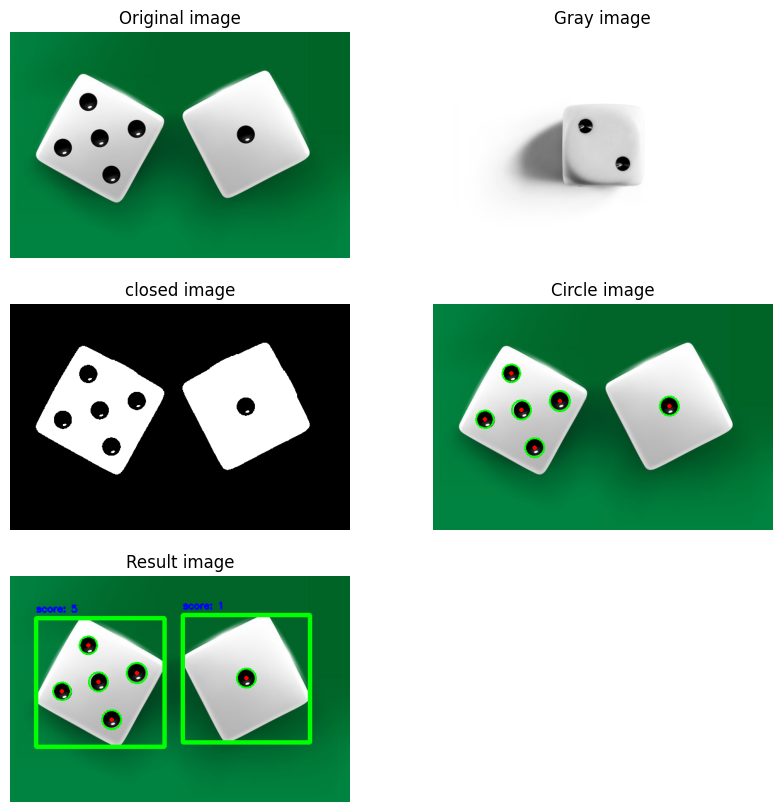

In [493]:
img = cv2.imread('/content/drive/MyDrive/Image_processing/Project/Project_2/img/two_dice_green.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#k = 3, minRadius = 3, maxRadius = 35, ite = 1, hinh 4
anh1, anh2, anh3, anh4 = process_dice_image(img, 3, 3, 35, 1, 4)
plt.figure(figsize=(10,10))
plt.subplot(3,2,1); plt.axis('off'); plt.imshow(img); plt.title("Original image")
plt.subplot(3,2,2); plt.axis('off'); plt.imshow(anh1, cmap='gray'); plt.title("Gray image")
plt.subplot(3,2,3); plt.axis('off'); plt.imshow(anh2, cmap='gray'); plt.title("closed image")
plt.subplot(3,2,4); plt.axis('off'); plt.imshow(anh3); plt.title("Circle image")
plt.subplot(3,2,5); plt.axis('off'); plt.imshow(anh4); plt.title("Result image")
plt.show()

Tổng hợp các bước làm thành hàm

In [451]:
def diceRecognition(img, c1, c2, threshValue, minRadius, maxRadius, hinh):
  #img là ảnh đầu vào
  #c1 là ngưỡng đầu canny
  #c2 là ngưỡng sau canny
  #threshValue là giá trị cắt ngưỡng
  #radius là bán

  #B1 chuyển ảnh về ảnh xám
  grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  #B2 tạo ảnh cắt ngưỡng
  _,thresh = cv2.threshold(grayImg,threshValue,255, cv2.THRESH_BINARY_INV)

  #B3 dùng canny để phát hiện cạnh
  edges = cv2.Canny(thresh, c1, c2, 3) #Ảnh closed

  #B4 đếm các hình tròn
  circles = cv2.HoughCircles(edges,cv2.HOUGH_GRADIENT,1.2,20,param1=c2,param2=25,minRadius=minRadius,maxRadius=maxRadius)
  circleImg = img.copy() #Ảnh circle
  #print(len(circles[0])) #Kiểm tra số lượng chấm tròn
  if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
      # Vẽ đường tròn
      cv2.circle(circleImg, (i[0], i[1]), i[2], (0, 255, 0), 2) #màu xanh lá
      # Vẽ tâm hình tròn
      cv2.circle(circleImg, (i[0], i[1]), 2, (255, 0, 0), 2) #màu đỏ
  #B5 đếm số lượng các xúc xắc có trên ảnh
  if(hinh == 2):
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  if(hinh == 3):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    dil = cv2.dilate(edges,kernel,iterations = 1)
    contours, hierarchy = cv2.findContours(dil, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  #print(len(contours)) #kiểm tra số lượng xx
  #B6 tiến hành vẽ các điền viền của xúc xắc và tách các ảnh chứa xúc xắc ra riêng
  resultImg = circleImg.copy() #Ảnh kết quả
  for contour in contours:
    # Vẽ đường viền
    x0, y0, w0, h0= cv2.boundingRect(contour)
    cv2.rectangle(resultImg, (x0,y0),(x0+w0,y0+h0), (0,255,0),5)


    # Tách các ảnh ra riêng
    dice = edges[y0:y0+h0, x0:x0+w0]

    # Xác định số lượng các chấm tròn trên ảnh riêng
    circles = cv2.HoughCircles(dice,cv2.HOUGH_GRADIENT,1.2,20,param1=150,param2=25,minRadius=3,maxRadius=35)

    # Ghi kết quả
    cv2.putText(resultImg, f'score: {len(circles[0])}', (x0, y0), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
  return grayImg, edges, circleImg, resultImg



Ảnh 2 xúc xắc

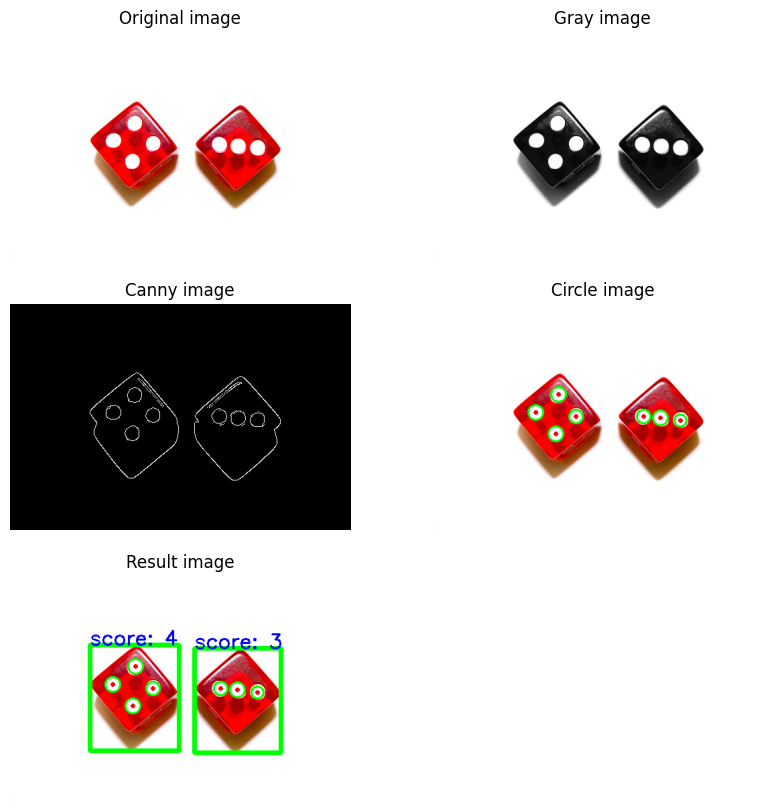

In [453]:
img = cv2.imread('/content/drive/MyDrive/Image_processing/Project/Project_2/img/two_dice.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#c1 = 9, c2 = 150, threshValue = 220, minRadius = 3, maxRadius = 35, hình 2
anh1, anh2, anh3, anh4 = diceRecognition(img, 9, 150, 220, 3, 35, 2)
plt.figure(figsize=(10,10))
plt.subplot(321); plt.axis('off'); plt.imshow(img); plt.title("Original image")
plt.subplot(322); plt.axis('off'); plt.imshow(anh1, cmap='gray'); plt.title("Gray image")
plt.subplot(323); plt.axis('off'); plt.imshow(anh2, cmap='gray'); plt.title("Canny image")
plt.subplot(324); plt.axis('off'); plt.imshow(anh3); plt.title("Circle image")
plt.subplot(325); plt.axis('off'); plt.imshow(anh4); plt.title("Result image")
plt.show()

Ảnh 3 xúc xắc

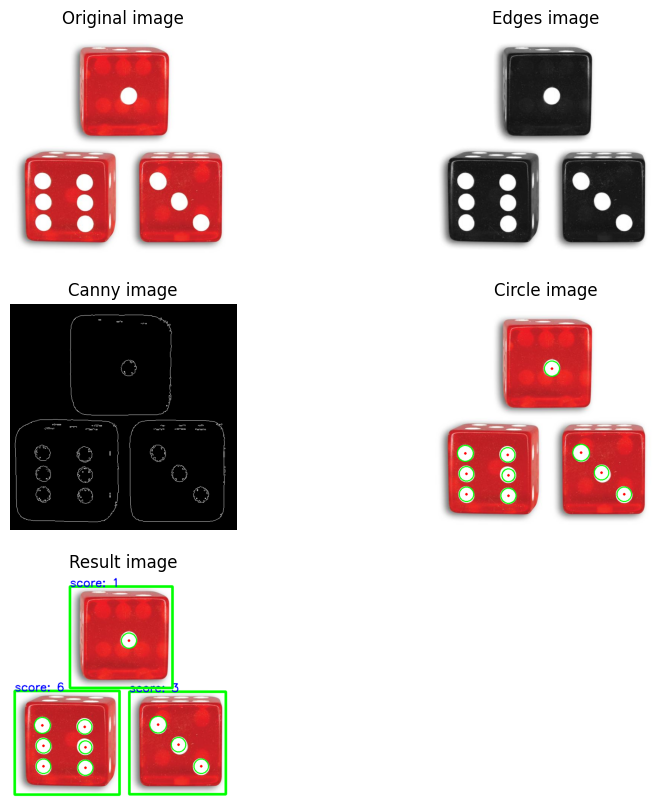

In [454]:
img = cv2.imread('/content/drive/MyDrive/Image_processing/Project/Project_2/img/three_dice.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#c1 = 9, c2 = 150, threshValue = 250, minRadius = 10, maxRadius = 35, hình 3
anh1, anh2, anh3, anh4 = diceRecognition(img, 9, 150, 250, 10, 35, 3)
plt.figure(figsize=(10,10))
plt.subplot(321); plt.axis('off'); plt.imshow(img); plt.title("Original image")
plt.subplot(322); plt.axis('off'); plt.imshow(anh1, cmap='gray'); plt.title("Edges image")
plt.subplot(323); plt.axis('off'); plt.imshow(anh2, cmap='gray'); plt.title("Canny image")
plt.subplot(324); plt.axis('off'); plt.imshow(anh3); plt.title("Circle image")
plt.subplot(325); plt.axis('off'); plt.imshow(anh4); plt.title("Result image")
plt.show()


Ảnh 2 xúc xắc nền xanh lá